<a href="https://colab.research.google.com/github/AmazingK2k3/Over_Squashing_GNNs/blob/main/MUTAG_GraphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import pandas as pd
import torch
import numpy as np
import os
import random
import sklearn
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import global_max_pool
from torch.nn import Sequential, Linear, ReLU


from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader



## Loading MUTAG Dataset



*  ## 1 indicates mutagenicity (causing genetic mutation)
*   ## 0 indicates no mutagenicity




## Parameters of the PyG data object
:
x (torch.Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)

edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)

edge_attr (torch.Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)

y (torch.Tensor, optional) – Graph-level or node-level ground-truth labels with arbitrary shape. (default: None)



In [ ]:
example = mutag[0]
y = example.x.shape  #([number of nodes, num_node_features])
print(y[0], y[1])

17 7


## Checking if all labels exist

In [ ]:
for i in range(len(mutag)):
  x = mutag[i]
  if x.y.size(0) == 0:
    print(x)



Negative


In [ ]:
from torch_geometric.datasets import TUDataset

mutag = TUDataset(root = '/content/drive/MyDrive/Mutag', name = 'MUTAG')
print("len:", len(mutag))
print("num_classes:", mutag.num_classes)
print("num_node_features:", mutag.num_node_features)

len: 188
num_classes: 2
num_node_features: 7


In [ ]:
mutag?

In [ ]:
for i in range(100):
  dx = mutag[i]
  #print(dx.edge_index.shape)
  print(dx.x.shape)


torch.Size([17, 7])
torch.Size([13, 7])
torch.Size([13, 7])
torch.Size([19, 7])
torch.Size([11, 7])
torch.Size([28, 7])
torch.Size([16, 7])
torch.Size([20, 7])
torch.Size([12, 7])
torch.Size([17, 7])
torch.Size([17, 7])
torch.Size([20, 7])
torch.Size([22, 7])
torch.Size([13, 7])
torch.Size([19, 7])
torch.Size([22, 7])
torch.Size([11, 7])
torch.Size([17, 7])
torch.Size([13, 7])
torch.Size([18, 7])
torch.Size([18, 7])
torch.Size([17, 7])
torch.Size([23, 7])
torch.Size([27, 7])
torch.Size([17, 7])
torch.Size([13, 7])
torch.Size([23, 7])
torch.Size([17, 7])
torch.Size([23, 7])
torch.Size([23, 7])
torch.Size([22, 7])
torch.Size([24, 7])
torch.Size([23, 7])
torch.Size([13, 7])
torch.Size([17, 7])
torch.Size([14, 7])
torch.Size([17, 7])
torch.Size([15, 7])
torch.Size([15, 7])
torch.Size([13, 7])
torch.Size([17, 7])
torch.Size([13, 7])
torch.Size([19, 7])
torch.Size([17, 7])
torch.Size([12, 7])
torch.Size([23, 7])
torch.Size([22, 7])
torch.Size([17, 7])
torch.Size([20, 7])
torch.Size([16, 7])


In [ ]:
mutag[18]

Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])

## Visualization

Graph 1
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


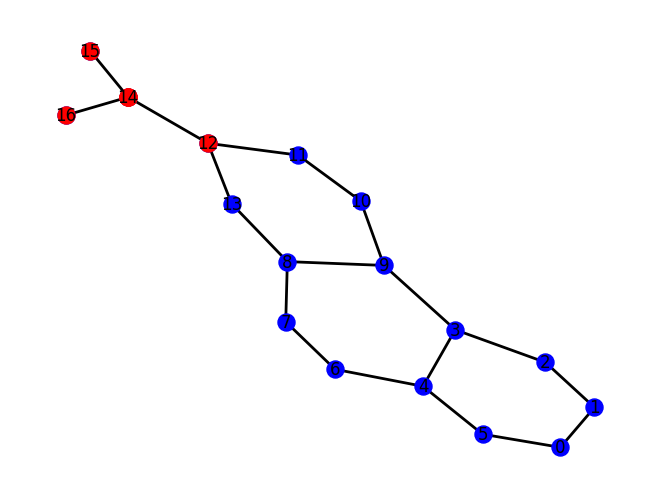

Graph 2
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


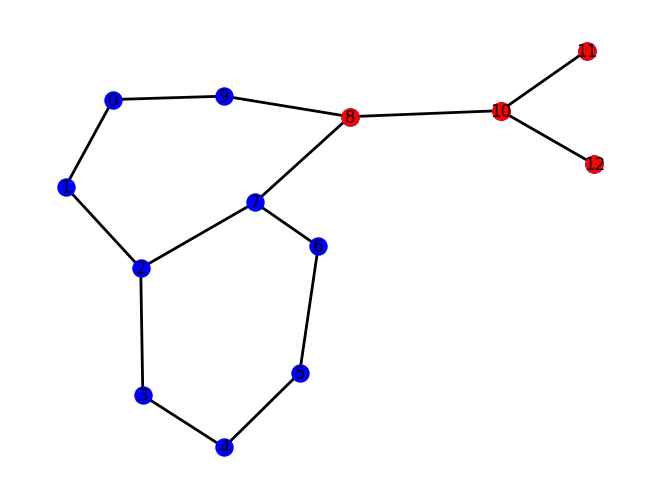

Graph 3
Data(edge_index=[2, 28], x=[13, 7], edge_attr=[28, 4], y=[1])


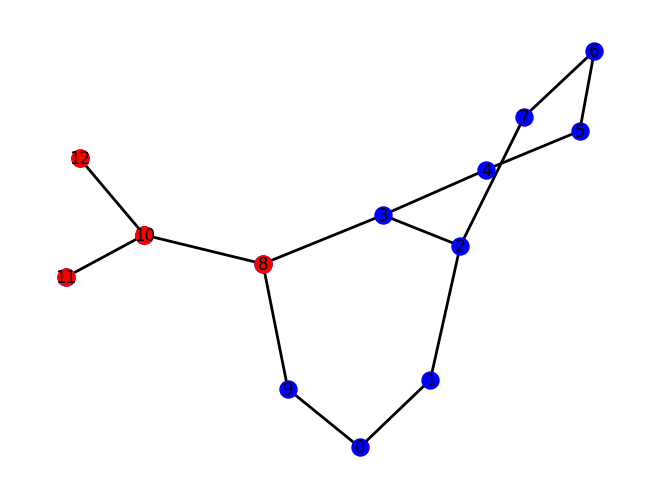

Graph 4
Data(edge_index=[2, 44], x=[19, 7], edge_attr=[44, 4], y=[1])


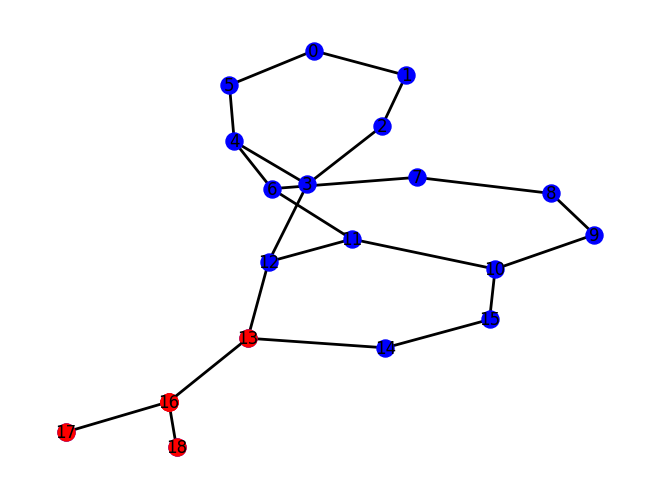

Graph 5
Data(edge_index=[2, 22], x=[11, 7], edge_attr=[22, 4], y=[1])


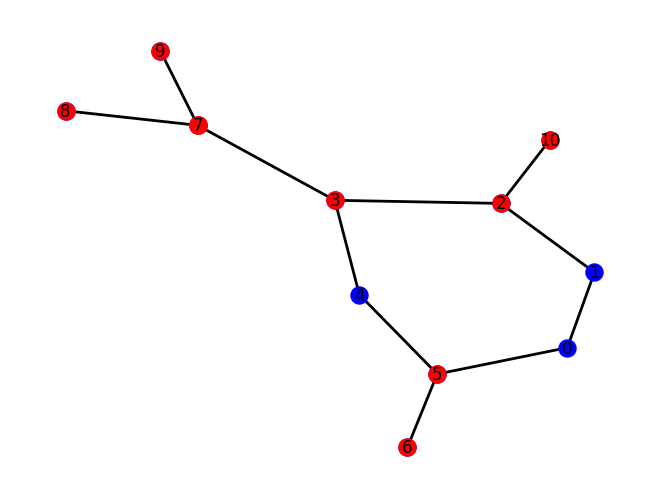

Graph 6
Data(edge_index=[2, 62], x=[28, 7], edge_attr=[62, 4], y=[1])


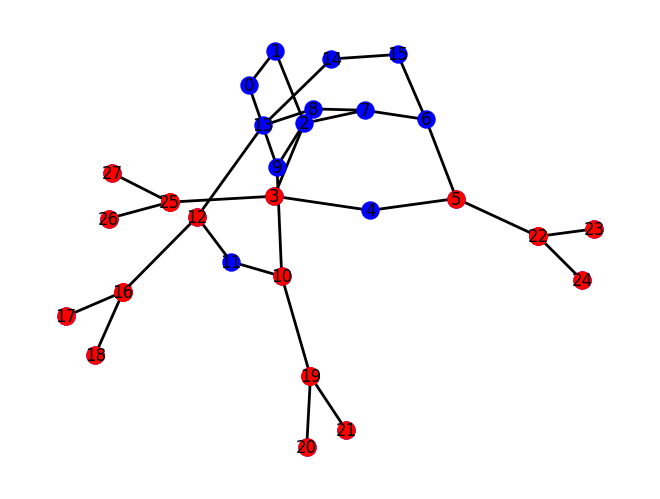

Graph 7
Data(edge_index=[2, 34], x=[16, 7], edge_attr=[34, 4], y=[1])


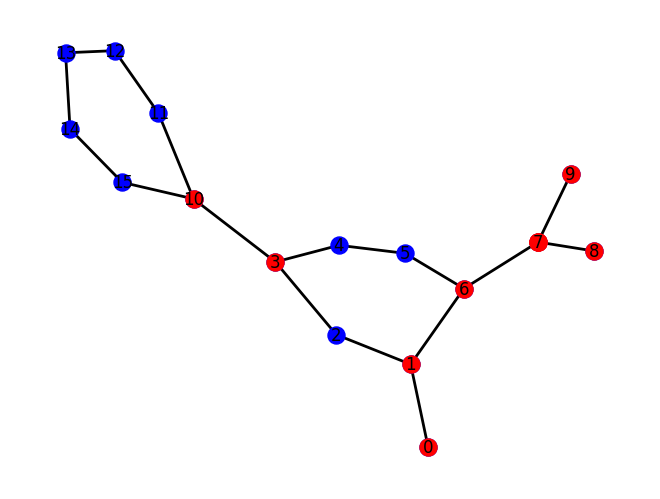

Graph 8
Data(edge_index=[2, 44], x=[20, 7], edge_attr=[44, 4], y=[1])


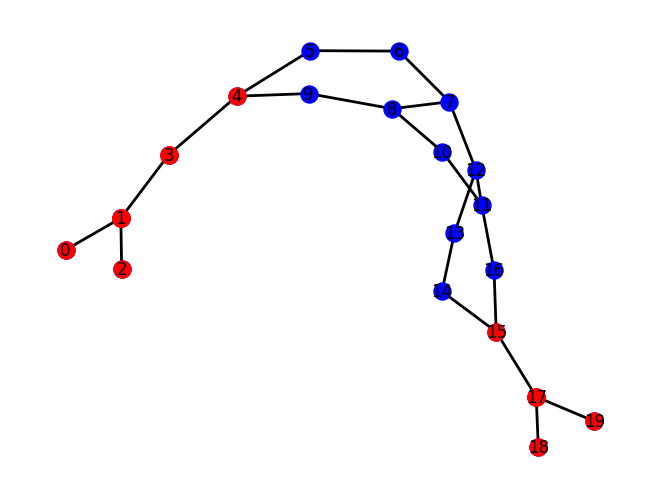

Graph 9
Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])


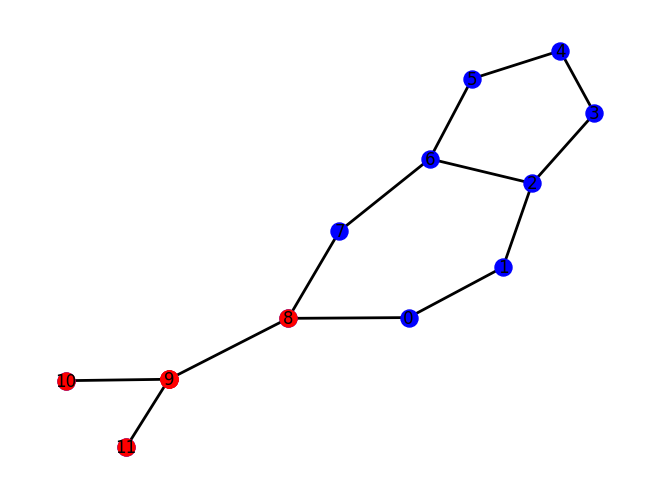

Graph 10
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


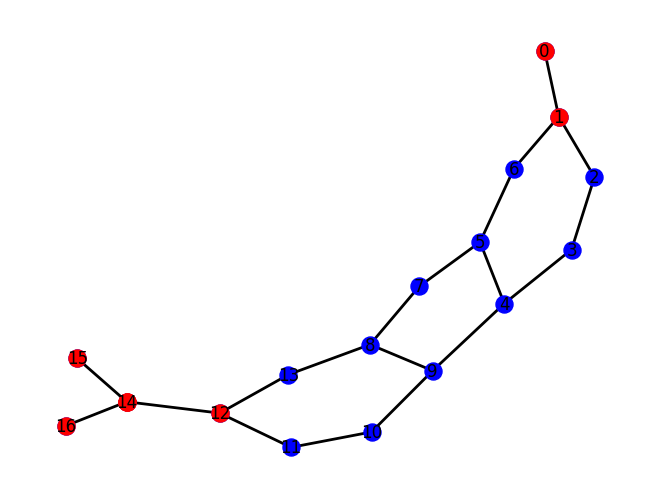

In [ ]:
for i in range(10):
  data = mutag[i]
  G = to_networkx(data,to_undirected = True)
  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color = 'blue', edge_color = 'black',
          node_size = 150, width = 2, with_labels = True)
  bridges = nx.bridges(G)
  print(f"Graph {i+1}")
  for bridge in bridges:
    nx.draw_networkx_nodes(G, pos, nodelist = bridge, node_color = 'red', node_size = 150)
  print(data)
  plt.show()

In [ ]:
data = list(mutag)
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

In [ ]:
print(f"Train_size, Test_Size, Val_size: {train_size}, {test_size}, {val_size}")


Train_size, Test_Size, Val_size: 150, 20, 18


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:


def loader(batch_size):
  train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(test_data, batch_size = 1 , shuffle = True)

  return train_loader, val_loader, test_loader

## GraphSAGE with normal wiring


In [ ]:
num_node_features = 7
# num_node_features is the number of node features.

# from binascii import a2b_hex

# from torch_geometric.nn import SAGEConv
# import itertools
# edges = list(itertools.permutations(range(18),2))
# full_adj = torch.tensor(edges,dtype = torch.long).t().contiguous().to(device)
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.sage1 = SAGEConv(num_node_features, dim_h) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4) # 64 * 32
        self.lin = Linear((dim_h//2), 1)  # 64 * 1

    def forward(self, x, edge_index, batch):

#(32x64 and 32x1)
        h1 = self.sage1(x, edge_index)
        h = F.elu(h1)
        h = F.dropout(h, p=0.5, training=self.training)
        h2 = self.sage2(h, edge_index)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)
        #h3 = self.sage3(h,full_adj)

       # print(h.shape)


        #h = torch.cat((a1,a2), dim = 1)
        h = global_mean_pool(h, batch)
       # print(h.shape) #32 * 64
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h)
        return torch.sigmoid(x)



## GraphSAGE with Full Adjacency

In [ ]:

# num_node_features is the number of node features.

# from binascii import a2b_hex
import itertools


class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.sage1 = SAGEConv(num_node_features, dim_h) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4) # 64 * 32
        self.lin = Linear((dim_h//2), 1)  # 64 * 1

    def forward(self, x, edge_index, batch):
        num_nodes = x.size(0)
        edges = list(itertools.permutations(range(num_nodes),2))
        full_adj = torch.tensor(edges,dtype = torch.long).t().contiguous().to(device)

        h1 = self.sage1(x, edge_index)
        h = F.elu(h1)
        h = F.dropout(h, p=0.5, training=self.training)
        h2 = self.sage2(h, full_adj)


       # print(h.shape)


        #h = torch.cat((a1,a2), dim = 1)
        h = global_mean_pool(h2, batch)
       # print(h.shape) #32 * 64
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h)
        return torch.sigmoid(x)



## GraphSAGE with Locally FA

In [ ]:

# num_node_features is the number of node features.

# from binascii import a2b_hex
import itertools


class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.sage1 = SAGEConv(num_node_features, dim_h) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4) # 64 * 32
        self.lin = Linear((dim_h//2), 1)  # 64 * 1

    def forward(self, x, edge_index, batch):
        num_nodes = x.size(0)
        edges = list(itertools.permutations(range(num_nodes),2))
        full_adj = torch.tensor(edges,dtype = torch.long).t().contiguous().to(device)

        h1 = self.sage1(x, edge_index)
        h = F.elu(h1)
        h = F.dropout(h, p=0.5, training=self.training)
        h2 = self.sage2(h, full_adj)


       # print(h.shape)


        #h = torch.cat((a1,a2), dim = 1)
        h = global_mean_pool(h2, batch)
       # print(h.shape) #32 * 64
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h)
        return torch.sigmoid(x)



## Loader Function

In [ ]:
def loader(batch_size):
  train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(test_data, batch_size = 1 , shuffle = True)

  return train_loader, val_loader, test_loader

## Result Functions


In [ ]:

def Roc_curve(labels, preds, model_name):
  fpr, tpr, thresholds = roc_curve(labels, preds)
  plt.figure(figsize = (4,4))
  plt.plot(fpr, tpr)
  plt.title(f"{model_name}")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])


In [ ]:
def save_classification_report_txt(report_str, model_name, file_path):
    with open(file_path, 'w') as f:
        f.write(f"Classification Report for {model_name}:\n")
        f.write(report_str)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def Confusion_matrix(confmat, model_name):


    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')


    ax.set_xticklabels(['']+['Not Mutagenic', 'Mutagenic'])
    ax.set_yticklabels(['']+['Not Mutagenic', 'Mutagenic'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"{model_name}")
    # ax.xaxis.set_label_position('top')

    plt.tight_layout()

    plt.show()



def c_matplot(model, test_loader, j):
  all_labels = []
  all_preds = []
  model_name = type(model).__name__
  #model.eval()
  #with torch.no_grad():
  for data in test_loader:
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.batch = data.batch.to(device)
    data.y = data.y.to(device)

    out = model(data.x, data.edge_index, data.batch)
    out = out.squeeze()
    out = (out >= 0.5).int()
    out = out.view(-1).detach().cpu().numpy()
    all_labels.extend(data.y.cpu().numpy())
    all_preds.extend(out)

  clf_rp = classification_report(all_labels, all_preds)
  save_classification_report_txt(clf_rp, model_name, f'/content/drive/MyDrive/Mutag_results/Clf_reports_mutag_Gs/exp{j}_{model_name}.txt')
  conf = confusion_matrix(y_true = all_labels, y_pred = all_preds)
  roc_curve = Roc_curve(all_labels, all_preds, model_name)
  return Confusion_matrix(conf, model_name),print(clf_rp), roc_curve


In [ ]:

def train(model, loader, lr, epochs,i):
  criterion = torch.nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  epochs = epochs
  model.train()

  train_accuracies = []
  val_accuracies = []
  best_val_acc = 0
  best_model_state = None
  for epoch in range(epochs+1):
    total_loss = 0
    acc = 0
    val_loss = 0
    val_acc = 0

    for data in loader:
      data.x = data.x.to(device)
      data.edge_index = data.edge_index.to(device)
      data.y = data.y.to(device).float()
      data.batch = data.batch.to(device)
      #data.y = data.y.view(-1,1)

      optimizer.zero_grad()
      out = model(data.x, data.edge_index, data.batch)
      out = out.view(-1)
      #print("Before view", out)
      loss = criterion(out, data.y)
      total_loss += loss/ len(loader)
      acc += accuracy(out, data.y)/len(loader)
      loss.backward()
      optimizer.step()

    val_loss, val_acc = test(model, val_loader)
    val_acc = round(val_acc,2)
    #print("val_acc",val_acc)
    val_accuracies.append(val_acc)

    #print(len(train_accuracies),len(val_accuracies))
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_train_acc = acc
      best_epoch = epoch
      best_model_state = model.state_dict()

   # print("best_val_acc",best_val_acc)
    train_accuracies.append(round(acc*100,2))
   # total_loss /= len(loader)
   # acc /= len(loader)


    if(epoch % 5 == 0):
      print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f}%')
    #print(len(val_accuracies), len(train_accuracies))


  model_name = type(model).__name__

  torch.save(best_model_state, f'/content/drive/MyDrive/Mutag_results/best_models/exp{i}_{model_name}.pth')
  model.load_state_dict(best_model_state)

  plt.figure(figsize=(8, 5))
  plt.plot(range(epochs + 1), train_accuracies, label='Training Accuracy')
  plt.plot(range(epochs + 1), val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title(f'Training vs. Validation Accuracy of {model_name}')
  plt.show()


  #return model, best_val_acc, best_train_acc, best_epoch
  return model, round(best_train_acc * 100, 2), round(best_val_acc, 2), best_epoch
@torch.no_grad()
def test(model, loader):
  criterion = torch.nn.BCELoss()
  #model.eval()
  loss = 0
  acc = 0

  for data in loader:
    data.x = data.x.to(device)
    data.edge_index = data.edge_index.to(device)
    data.y = data.y.to(device).float()
    data.batch = data.batch.to(device)


    out = model(data.x, data.edge_index, data.batch)
    #print("Output shape:", out.shape)
    #print("Target shape:", data.y.shape)

    out = out.view(-1)

    loss += criterion(out, data.y.float())/len(loader)
    acc  += accuracy(out, data.y)/len(loader)

  return loss, round(acc *100, 2)


def accuracy(pred_y, y):
  #print("Before Squeeze", pred_y)
  pred = pred_y.squeeze()
  #print("After Squeeze", pred)
  pred = (pred >= 0.5).float()
  #print("After thresholding", pred)
  return (pred == y).sum().item()/len(y)

# Logs:
# the validation accuracy has been pushed to the epoch for loop, have to run the models again and check how the metrics are changing.
# Check if the best model is the one that is being returned.
# Perform all three experiments with the learning rate set to 0.01


Epoch   0 | Train Loss: 0.66 | Train Acc: 60.85% | Val Loss: 0.58 | Val Acc: 72.22%
Epoch   5 | Train Loss: 0.61 | Train Acc: 66.76% | Val Loss: 0.55 | Val Acc: 72.22%
Epoch  10 | Train Loss: 0.59 | Train Acc: 67.95% | Val Loss: 0.51 | Val Acc: 72.22%
Epoch  15 | Train Loss: 0.58 | Train Acc: 67.39% | Val Loss: 0.48 | Val Acc: 72.22%
Epoch  20 | Train Loss: 0.57 | Train Acc: 66.14% | Val Loss: 0.45 | Val Acc: 77.78%
Epoch  25 | Train Loss: 0.58 | Train Acc: 68.92% | Val Loss: 0.46 | Val Acc: 77.78%
Epoch  30 | Train Loss: 0.55 | Train Acc: 72.10% | Val Loss: 0.43 | Val Acc: 77.78%
Epoch  35 | Train Loss: 0.56 | Train Acc: 72.33% | Val Loss: 0.45 | Val Acc: 72.22%
Epoch  40 | Train Loss: 0.53 | Train Acc: 72.33% | Val Loss: 0.47 | Val Acc: 83.33%
Epoch  45 | Train Loss: 0.53 | Train Acc: 73.52% | Val Loss: 0.43 | Val Acc: 77.78%
Epoch  50 | Train Loss: 0.51 | Train Acc: 74.49% | Val Loss: 0.46 | Val Acc: 72.22%
Epoch  55 | Train Loss: 0.53 | Train Acc: 72.95% | Val Loss: 0.45 | Val Acc:

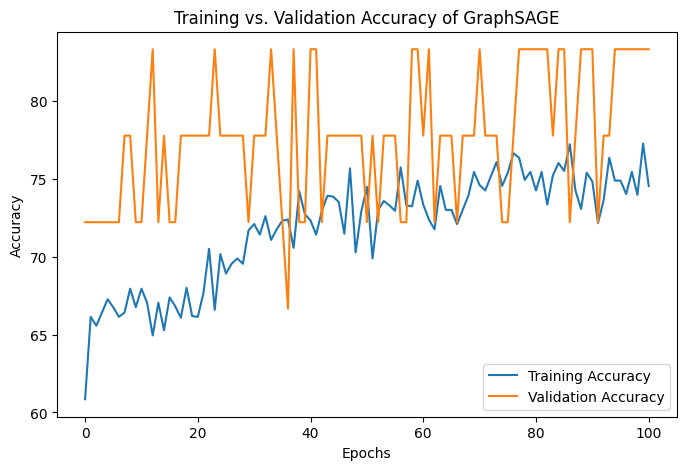

Test Loss: 0.634860634803772 | Test Acc: 60.0%
Training Accuracy: 64.94| Validation Accuracy: 83.33| Epoch: 12


In [ ]:
batch_size = 32
train_loader, val_loader, test_loader = loader(batch_size = batch_size)
sage  = GraphSAGE(dim_h = 128).to(device)
model = sage
model, train_acc, val_acc, epochs = train(model, train_loader, lr = 0.001, epochs = 100, i = 1)
test_loss, test_acc = test(model, test_loader)


print(f'Test Loss: {test_loss} | Test Acc: {test_acc}%')
print(f'Training Accuracy: {train_acc}| Validation Accuracy: {val_acc}| Epoch: {epochs}')


In [ ]:
# batch_size = 16
# train_loader, val_loader, test_loader = loader(batch_size = batch_size)
# trained_models_2 = []
# models = [GCN, GCN_m, GIN, GAT, GraphSAGE]
# testing_acc_2 = []
# training_acc_2 = []
# validation_acc_2 = []
# epoch_2 = []
# for model in models:
#   num_node_features = 9
#   model = model(dim_h = 32).to(device)
#   model, train_acc, val_acc, epochs = train(model, train_loader, 0.001, 100,2)
#   trained_models_2.append(model)
#   test_loss, test_acc = test(model, test_loader)
#   testing_acc_2.append(test_acc)
#   training_acc_2.append(train_acc)
#   validation_acc_2.append(val_acc)
#   epoch_2.append(epochs)
#   print(f'Test Loss: {test_loss : 2f} | Test Acc: {test_acc: 2f}%')

# dict = {'Train_acc': training_acc_2, 'Test_acc': testing_acc_2, 'Val_acc':validation_acc_2, 'Epoch': epoch_2}
# df = pd.DataFrame(dict)
# df.to_csv('/content/drive/MyDrive/graph_data/Metrics/exp2.csv')

<ipython-input-17-d7636db4af5b>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['Not Seizure', 'Seizure'])
<ipython-input-17-d7636db4af5b>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['Not Seizure', 'Seizure'])


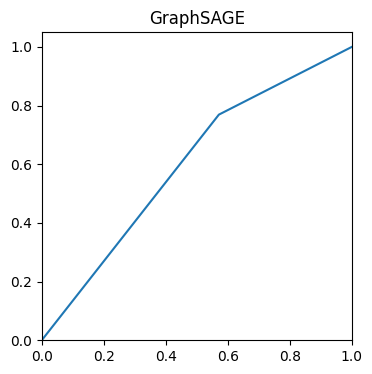

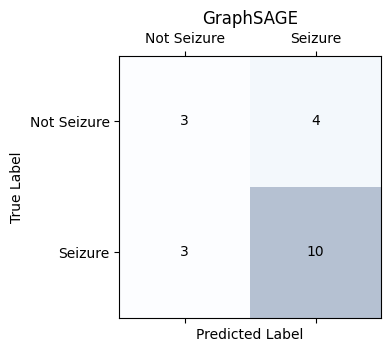

              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.71      0.77      0.74        13

    accuracy                           0.65        20
   macro avg       0.61      0.60      0.60        20
weighted avg       0.64      0.65      0.64        20



(None, None, None)

In [ ]:
c_matplot(model, test_loader,1)